<a href="https://colab.research.google.com/github/nomuyu00/baysian_optimization/blob/master/%E9%AB%98%E6%AC%A1%E5%85%83%E3%83%99%E3%82%A4%E3%82%BA%E6%9C%80%E9%81%A9%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      !pip install torch
      pbar.update(20)
      !pip install botorch==0.8.5
      pbar.update(30)
      !pip install gpytorch
      pbar.update(20)
      !pip install numpy
      !pip install matplotlib
      pbar.update(30)
except subprocess.CalledProcessError:
  print(captured)
  raise


  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

In [ ]:
import torch
from botorch import fit_gpytorch_model
from botorch.acquisition import UpperConfidenceBound
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
import numpy as np
import matplotlib.pyplot as plt

# 目的関数の用意

In [ ]:
def styblinski_tang(x):
    return 0.5 * torch.sum(x ** 4 - 16 * x ** 2 + 5 * x, dim=-1)

In [ ]:
def rosenbrock(x):
    return torch.sum(100.0 * (x[..., 1:] - x[..., :-1]**2)**2 + (1 - x[..., :-1])**2, dim=-1)

In [ ]:
# styblinski_tangを使う場合
#global_optimum = -39.16599 * 25

# rosenbrockを使う場合
global_optimum = 0.0

# 初期点の生成関数

In [ ]:
def generate_initial_points(n_initial, dim, bounds):
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]

# モデル作成関数


In [ ]:
def create_model(train_X, train_Y):
    kernel = ScaleKernel(RBFKernel(ard_num_dims=train_X.shape[-1]))
    model = SingleTaskGP(train_X, train_Y, covar_module=kernel)
    return model


# **ドロップアウトベイズクラス(Dropout-mix)**

In [ ]:
class DropoutMixBO_Mix:
    def __init__(self, dim, active_dim, bounds, n_initial, dropout_prob=0.1):
        self.dim = dim
        self.active_dim = active_dim
        self.bounds = bounds
        self.dropout_prob = dropout_prob
        self.X = generate_initial_points(n_initial, dim, bounds)
        self.Y = rosenbrock(self.X)
        self.best_f = self.Y.min().item()
        self.best_x = self.X[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_active, q=1, num_restarts=5, raw_samples=20,
            )

            x_new = torch.zeros(self.dim)
            if np.random.random() < self.dropout_prob:
                x_new[active_dims] = candidate.squeeze()
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = rosenbrock(x_new.unsqueeze(0))

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

# **ドロップアウトベイズクラス(p=0)(Dropout_copy)**

In [ ]:
class DropoutMixBO_Copy:
    def __init__(self, dim, active_dim, bounds, n_initial, dropout_prob=0.0):
        self.dim = dim
        self.active_dim = active_dim
        self.bounds = bounds
        self.dropout_prob = dropout_prob
        self.X = generate_initial_points(n_initial, dim, bounds)
        self.Y = rosenbrock(self.X)
        self.best_f = self.Y.min().item()
        self.best_x = self.X[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_active, q=1, num_restarts=5, raw_samples=20,
            )

            x_new = torch.zeros(self.dim)
            if np.random.random() < self.dropout_prob:
                x_new[active_dims] = candidate.squeeze()
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = rosenbrock(x_new.unsqueeze(0))

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

# **ドロップアウトベイズクラス(p=1)(Dropout-Random)**

In [ ]:
class DropoutMixBO_Random:
    def __init__(self, dim, active_dim, bounds, n_initial, dropout_prob=1.0):
        self.dim = dim
        self.active_dim = active_dim
        self.bounds = bounds
        self.dropout_prob = dropout_prob
        self.X = generate_initial_points(n_initial, dim, bounds)
        self.Y = rosenbrock(self.X)
        self.best_f = self.Y.min().item()
        self.best_x = self.X[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_active, q=1, num_restarts=5, raw_samples=20,
            )

            x_new = torch.zeros(self.dim)
            if np.random.random() < self.dropout_prob:
                x_new[active_dims] = candidate.squeeze()
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = rosenbrock(x_new.unsqueeze(0))

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

#最適化の実行


In [ ]:
dim = 25
active_dim = 5
bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
n_initial = 200
n_iter = 100

In [ ]:
dropout_bo_mix = DropoutMixBO_Mix(dim, active_dim, bounds, n_initial)
dropout_bo_copy = DropoutMixBO_Copy(dim, active_dim, bounds, n_initial)
dropout_bo_random = DropoutMixBO_Random(dim, active_dim, bounds, n_initial)

In [ ]:
try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      dropout_mix_best_x , dropout_mix_best_f = dropout_bo_mix.optimize(n_iter)
      pbar.update(33)
      dropout_copy_best_x , dropout_copy_best_f = dropout_bo_copy.optimize(n_iter)
      pbar.update(33)
      dropout_random_best_x , dropout_random_best_f = dropout_bo_random.optimize(n_iter)
      pbar.update(34)
except subprocess.CalledProcessError:
  print(captured)
  raise

/usr/local/lib/python3.10/dist-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is str

# 結果のプロット

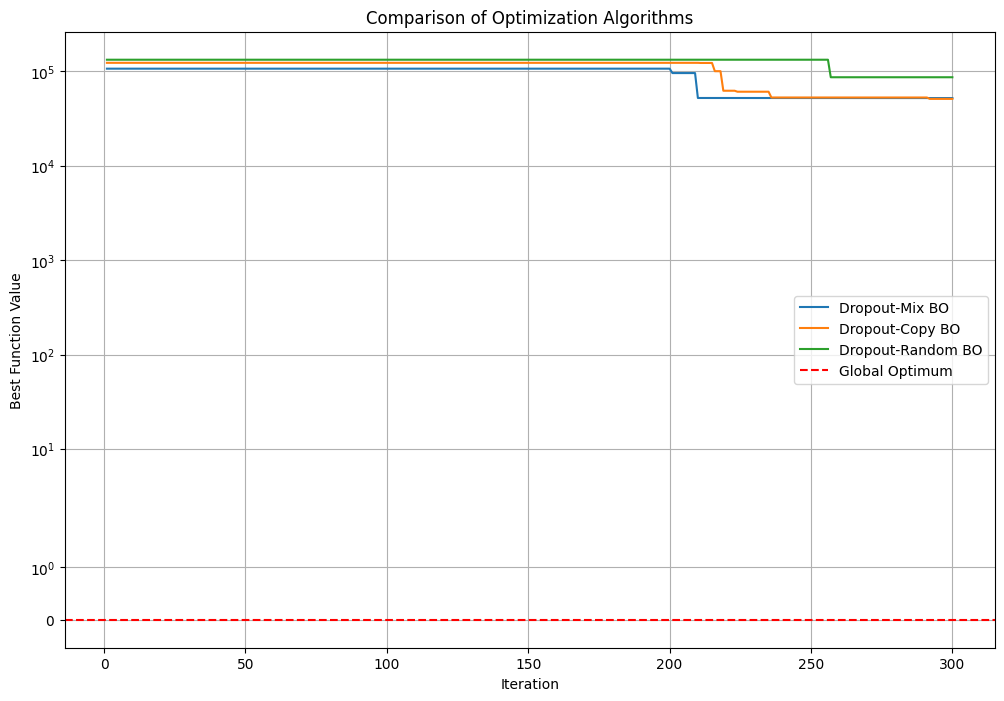

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_mix.eval_history, label='Dropout-Mix BO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_copy.eval_history, label='Dropout-Copy BO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_random.eval_history, label='Dropout-Random BO')
plt.axhline(y=global_optimum, color='r', linestyle='--', label='Global Optimum')
plt.xlabel('Iteration')
plt.ylabel('Best Function Value')
plt.title('Comparison of Optimization Algorithms')
plt.legend()
plt.yscale('symlog')
plt.grid(True)
plt.show()

dropout_